![Py4Eng](img/logo.png)

# Feed Forward Network with Keras
## Yoav Ram

In this session we will understand:
- what is Keras
- how to use Keras to construct and train a feed forward networks
- how to save trained models and then load them to re-train or predict with them

**Please use the correct kernel**: in the notebook menu bar, click `Kernel`, then `Change kernel...` then choose `conda_tensorflow2_p38`.

# Keras

[Keras](https://keras.io/) "Deep learning for humans": it is a high-level neural networks API, written in Python and capable of running on top of [TensorFlow, JAX, and PyTorch](https://keras.io/keras_core/announcement/).

The main benefit is that it *allows for easy and fast prototyping*.

To use Keras, will need to install [TensorFlow](https://www.tensorflow.org/install).

# TensorFlow

[TensorFlow™](https://www.tensorflow.org/) is an **open source** software library for **numerical computation** using **data flow graphs**. **Nodes** in the graph represent **mathematical operations**, while the graph **edges** represent the multidimensional **data arrays** (tensors) communicated between them. 

The flexible architecture allows you to **deploy** computation to one or more **CPUs** or **GPUs** in a **desktop, server, mobile device, or cluster**, with a single API. 

TensorFlow is developed by researchers and engineers working on the **Google Brain Team** within **Google's Machine Intelligence research organization** for the purposes of conducting **machine learning and deep neural networks research**, but the system is general enough to be applicable in a wide variety of other domains as well.

TensorFlow is installed with Anaconda.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
import keras

print('Tensorflow:', tf.__version__)    
print('Keras:', keras.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2023-11-08 22:27:38.179790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.13.1
Keras: 2.13.1
GPU: []



# Classifiying images

Let's use Keras for the [softmax](softmax-model.ipynb) and [FFN](FFN.ipynb) models we developed previously.

We use Keras' datasets module to load the data:

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [3]:
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [4]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

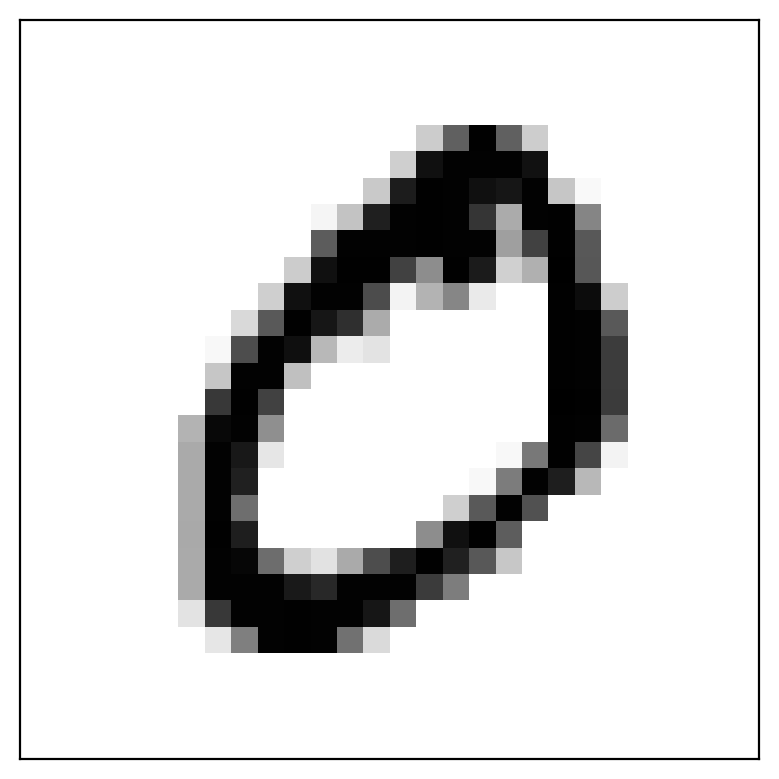

In [6]:
def display_image(im):
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
display_image(X_train[1])

# Softmax model

A Keras model can be built by defining the model layers, then giving them to the `Sequential` model object.
You could also first create the model object and the use its `add` method to add layers.

A `Dense` layer uses matrix muliplication. We need to provide it with the number of outputs, in this case the number of categories, and the activation function, in this case the softmax function.

A `Flatten` layer just flatten the input data - turns it into a 1D array.
The first layer always has to be told the shape of the input (`X`).

In [7]:
layers = [
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(ncats, activation='softmax')
]
model = keras.models.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next, we need to compile the Keras model, configuring it for training.

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Finally, we can train or fit the model. 

In [9]:
history = model.fit(
    X_train, Y_train,
    batch_size=50,
    epochs=30,
    validation_data=(X_test, Y_test)
).history

Epoch 1/30
1200/1200 [==============================] - 2s 1ms/step - loss: 0.9047 - accuracy: 0.7918 - val_loss: 0.5560 - val_accuracy: 0.8717
Epoch 2/30
1200/1200 [==============================] - 1s 1ms/step - loss: 0.5156 - accuracy: 0.8711 - val_loss: 0.4479 - val_accuracy: 0.8890
Epoch 3/30
1200/1200 [==============================] - 1s 983us/step - loss: 0.4463 - accuracy: 0.8830 - val_loss: 0.4041 - val_accuracy: 0.8968
Epoch 4/30
1200/1200 [==============================] - 1s 1ms/step - loss: 0.4122 - accuracy: 0.8896 - val_loss: 0.3797 - val_accuracy: 0.9001
Epoch 5/30
1200/1200 [==============================] - 1s 1ms/step - loss: 0.3909 - accuracy: 0.8946 - val_loss: 0.3632 - val_accuracy: 0.9036
Epoch 6/30
1200/1200 [==============================] - 1s 987us/step - loss: 0.3760 - accuracy: 0.8974 - val_loss: 0.3514 - val_accuracy: 0.9061
Epoch 7/30
1200/1200 [==============================] - 1s 1000us/step - loss: 0.3647 - accuracy: 0.9000 - val_loss: 0.3428 - val_ac

Save the model and the training history:

In [10]:
model.save('../data/keras_ffn_model.keras')
with open("../data/keras_ffn_history.p", "wb") as f:
    pickle.dump(history, f)

Load the model and the history:

In [11]:
model = keras.models.load_model('../data/keras_ffn_model.keras')
with open("../data/keras_ffn_history.p", "rb") as f:
    history = pickle.load(f)

Next, plot the training history.

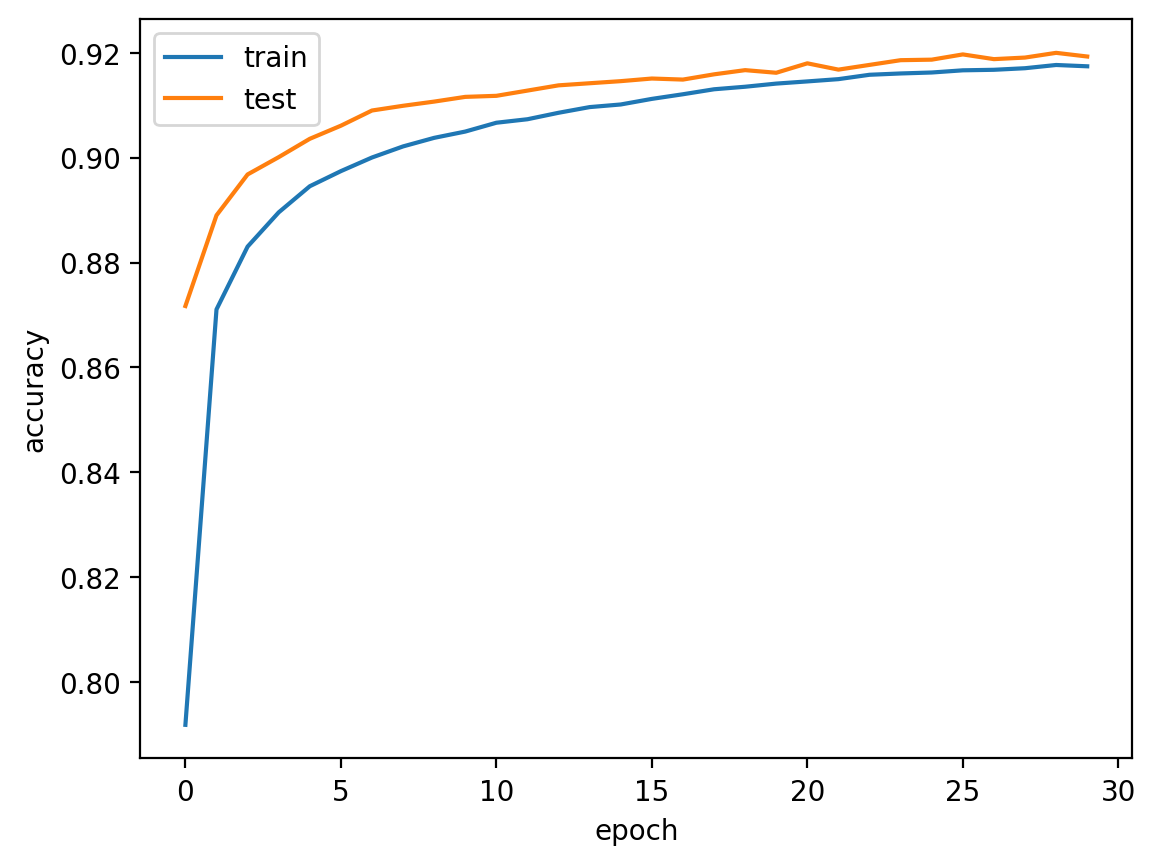

In [12]:
def plot_history(history):
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

plot_history(history)

We can also use the model to make predictions:

In [16]:
idx = 0
yhat = model.predict(X_test[idx:idx+1])
print(
    "Truth: {}, Prediction: {} ({:.4f})".format(
        Y_test[idx].argmax(), yhat.argmax(), yhat.max()
))

1/1 [==============================] - 0s 19ms/step
Truth: 7, Prediction: 7 (0.9956)


# Exercise: Feed forward with one hidden layer

Let's add a hidden layer so that we have:
$$
\mathbf{H} = ReLU(\mathbf{X} \cdot \mathbf{W_1} + b_1) $$$$
\mathbf{\widehat Y} = softmax(\mathbf{H} \cdot \mathbf{W_2} + b_2) \\
$$
Create a new model, with an additional hidden layer, compile it, and fit it.
Use the Adam optimizer instead of Stochastic Gradient Descent.

Then save the history and the model to `../data/keras_ffn2_history.p` and `../data/keras_ffn2_model.keras`.

A solution is [available](../solutions/K_FFN.ipynb).

In [17]:
# your code here

In [18]:
# your code here

In [ ]:
# your code here

In [20]:
model.save('../data/keras_ffn2_model.keras')
with open("../data/keras_ffn2_history.p", "wb") as f:
    pickle.dump(history, f)

In [23]:
model = keras.models.load_model('../data/keras_ffn2_model.keras')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Final test accuracy 0.9764


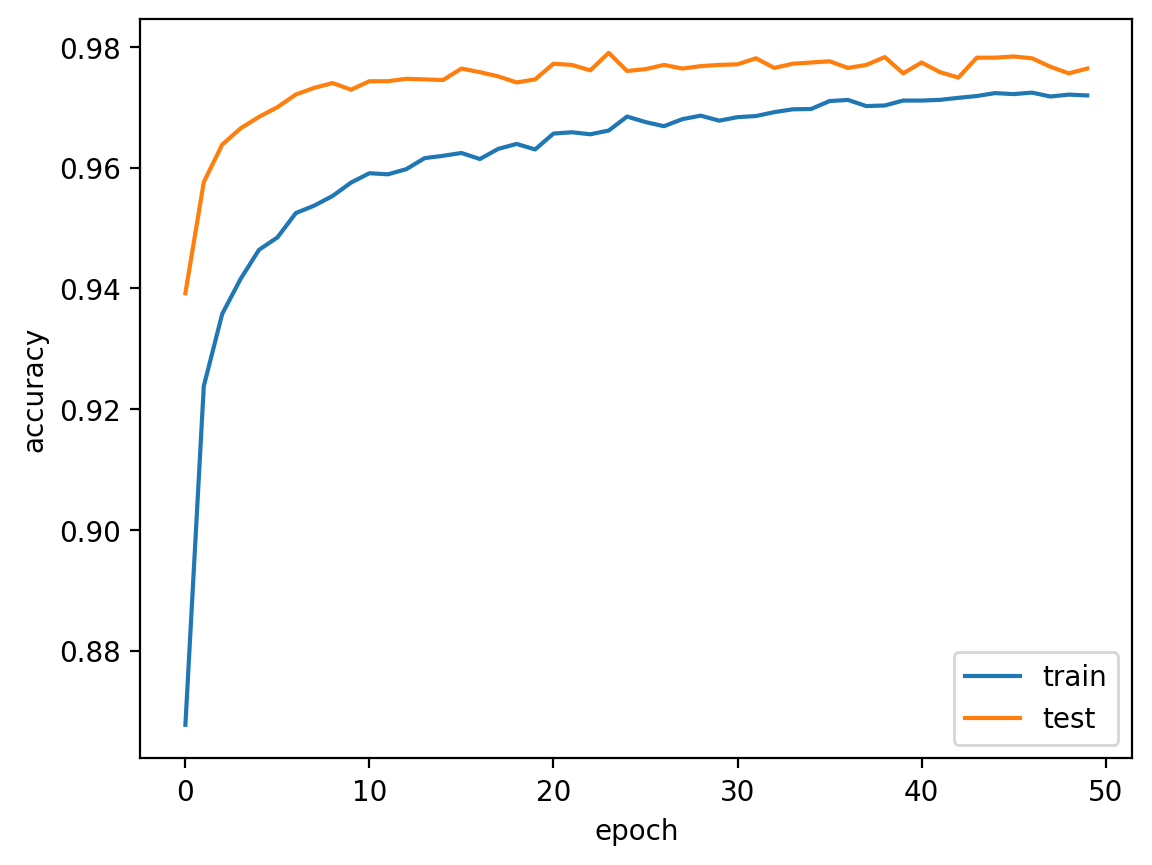

In [24]:
with open("../data/keras_ffn2_history.p", "rb") as f:
    history = pickle.load(f)
plot_history(history)
print("Final test accuracy {:.4f}".format(history['val_accuracy'][-1]))

# Exercise

Use a feed forward or convolutional network to classify images in the [Fashion-MNIST](../exercises/CNN.ipynb) dataset.

# References

- Keras [docs](https://keras.io)
- See the [Keras examples library](https://github.com/keras-team/keras/tree/master/examples)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)